In [13]:
import matplotlib.pyplot as plt

import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

# import matplotlib as plt

# import matplotlib

Изменил структуру кода для чтения аудио, вычисления фич и их сохранения. Надеюсь сделал удобнее.
Увеличил кол-во мелов до 128 и соответственно размер окна до 2048

In [2]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db

from sklearn.model_selection import train_test_split

def make_log_melspectrogram(path, sr, fft_size, hop, n_mels):
    wav_data, sr = load_wav(path, sr=sr)
    
    if len(wav_data) == 0:
        wav_data = np.zeros(sr)
    
    mel_spec = melspectrogram(y=wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
    return power_to_db(mel_spec, ref=np.max)

def store_train_features(file_label:dict, path_to_files, out_path, sr, fft_size, hop, n_mels):
    feats = []
    
    print('Total files:', len(file_label))
    
    for i, (file_name, label) in tqdm(enumerate(file_label.items())):
        feats.append({
            'fname': file_name,
            'feature': make_log_melspectrogram(os.path.join(path_to_files, file_name), sr, fft_size, hop, n_mels),
            'label_id': label
        })
        
    pickle.dump(feats, open(out_path, 'wb'))

def store_test_features(path_to_files, out_path, sr, fft_size, hop, n_mels):
    feats = []
    
    for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
        feats.append({
            'fname': file_name,
            'feature': make_log_melspectrogram(os.path.join(path_to_files, file_name), sr, fft_size, hop, n_mels)
        })
        
    pickle.dump(feats, open(out_path, 'wb'))

def read_labels_info(path_to_csv):
    meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])
    label_to_id = {label: i for i, label in enumerate(set(meta['label']))}
    meta['label_id'] = [label_to_id[label] for label in meta['label']]
    
    return meta
    
def make_file_label_dict(labels_info):
    return dict(zip(labels_info['fname'].values, labels_info['label_id'].values))

In [15]:
train_folder = '../../data/train/'
# test_folder = './data/audio_test/'

sample_rate = 22050
fft_size = 2048
overlap = 4
hop = fft_size // overlap
mels = 128

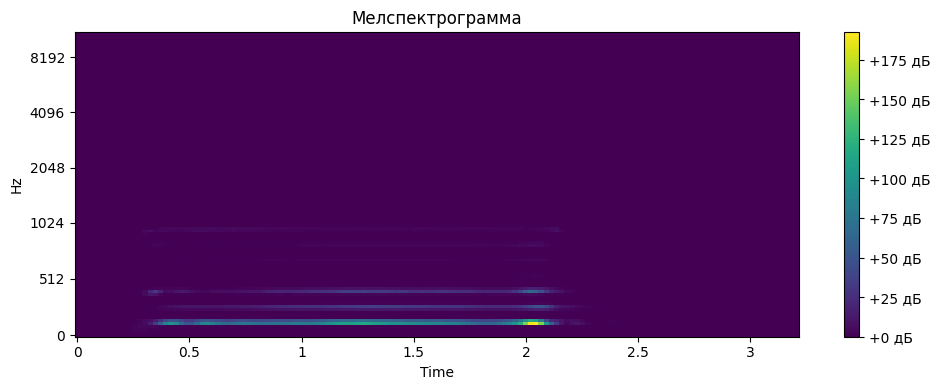

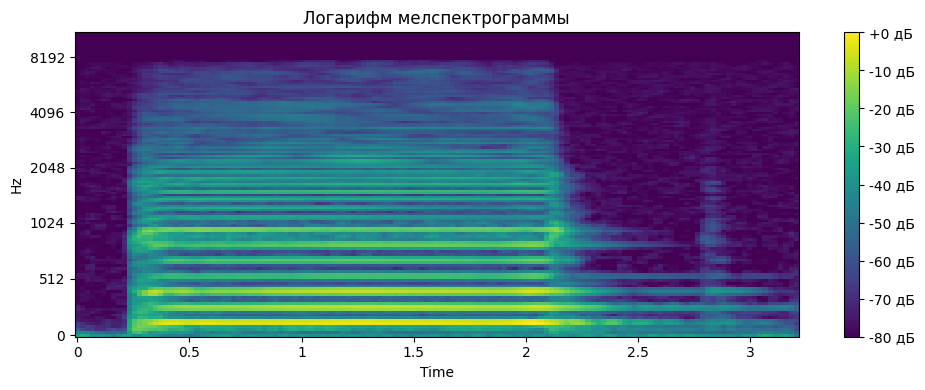

In [4]:
plt.close()

wav_data, sr = load(os.path.join(train_folder, '00abfb8903f34a38d7c3.wav'), sr=sample_rate)
mel_spec = melspectrogram(y=wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sample_rate//2)

plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')#
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')#
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

plt.close()

In [5]:
path_to_csv = os.path.join('../../data/', 'train.csv')

labels_info = read_labels_info(path_to_csv)

pickle_train_path = os.path.join('train.pickle')
# pickle_test_path = os.path.join('./data', 'test.pickle')

store_train_features(make_file_label_dict(labels_info), train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
# store_test_features(test_folder, pickle_train_path, sample_rate, fft_size, hop, mels)

Total files: 5683


5683it [04:05, 23.13it/s]


В структуру нейросети добавил еще один сверточный слой и соответствующие ему dropout и номрализацию.

In [5]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self):
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=96, out_channels=64, kernel_size=3, stride=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=15, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        self.dropout4 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.bn2 = nn.BatchNorm2d(num_features=96)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=32)
        
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(51200, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout4(x)
        
        x = self.flat(x)
        
#         x = self.activation1(self.linear1(x))
#         x = self.activation2(self.linear2(x))
        
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [6]:
random_input = torch.randn(1, 1, 128, 128, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[-1.0592,  0.8744, -0.3444, -1.4508, -0.5276,  1.5821, -1.5542,  1.8958,
          1.0269, -0.3456, -1.2109, -0.2412, -0.3230, -0.3931, -0.5955, -1.3030,
          0.6624,  0.8120,  0.1128, -0.5327, -0.6795, -0.1139,  0.1918,  1.6053,
         -1.5512,  0.4768,  0.1180,  0.5654, -1.1660,  0.0942,  0.1234, -0.1843,
         -0.7940,  0.1729, -0.3917,  0.5471, -1.9757,  0.5017,  0.1067, -0.1795,
          0.3926]], grad_fn=<AddmmBackward0>)


In [7]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 128, 128, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

3.8898727893829346


In [8]:
import pickle
import os

pickle_train_path = os.path.join('train.pickle')
pickle_train_data = pd.DataFrame(pickle.load(open(pickle_train_path, 'rb')))
pickle_train_data

,fname,feature,label_id
0,8bcbcc394ba64fe85ed4.wav,"[[-40.181625, -40.12136, -40.25932, -41.33498,...",37
1,00d77b917e241afa06f1.wav,"[[-47.539627, -48.90869, -50.098663, -48.81872...",12
2,17bb93b73b8e79234cb3.wav,"[[-58.852516, -63.83928, -62.65873, -63.082672...",29
3,7d5c7a40a936136da55e.wav,"[[-60.840748, -49.062775, -45.328495, -49.5021...",34
4,17e0ee7565a33d6c2326.wav,"[[-29.862686, -34.43574, -44.092243, -47.65063...",33
...,...,...,...
5678,edd5f2d5bdab597ab6f1.wav,"[[-39.930977, -37.56494, -38.40815, -41.8678, ...",21
5679,cc489c6414c2c25bfa6d.wav,"[[-11.155272, -10.985653, -20.634724, -29.0672...",25
5680,ac3177fbe1f9b0155920.wav,"[[-38.57271, -37.37361, -38.01863, -38.87619, ...",21
5681,9da56639ef3113293961.wav,"[[-11.727897, -16.986383, -31.695839, -40.2082...",33


Разделяю данные на тренировачные и валидационные с помощью train_test_split от sklearn. В соотношении 1 к 3.

In [9]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(pickle_train_data['feature'].values, 
                                            pickle_train_data['label_id'].values, 
                                            test_size=0.25)

Добави в функцию получения данных сдвиг на случайное значение

In [10]:
from torch.utils.data import Dataset
import random

def prepare_shape(feature):
    tmp = feature
    N = 128 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    random_shift = random.randint(0, (tmp.shape[1] - N) // 4)
    tmp = tmp[np.newaxis, :, random_shift : N + random_shift]
    return tmp

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.y is not None:
            return prepare_shape(self.x[idx]), self.y[idx]
        return prepare_shape(self.x[idx])

In [11]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)

15


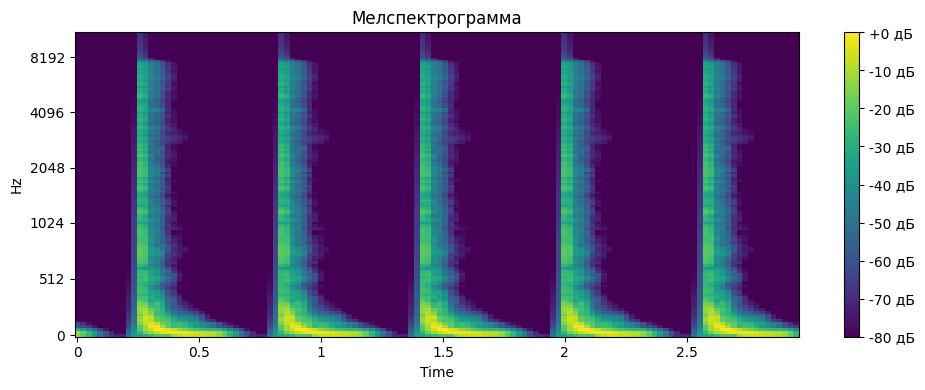

In [16]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

In [18]:
from sklearn.metrics import accuracy_score

* Пытаюсь использовать видиокарту в вычислениях. Нейросеть перевожу на cuda и данные перед загрузкой.
* Увеличил кол-во эпох обучения.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epoch = 150
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
network.to(device)
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.SGD(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x.to(device))
        outputs.append(output.argmax(axis=1))
    
        target = y.to(device)
        targets.append(target)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x.to(device))
            outputs.append(output.argmax(axis=1))

            target = y.to(device)
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 3.374250673330747
train accuracy: 0.1330361332707649
mean val loss: 2.996769639423915
val accuracy: 0.1597466572836031
epoch # 1
mean train loss: 2.775882748457102
train accuracy: 0.2339277334584702
mean val loss: 2.7680737495422365
val accuracy: 0.24278676988036593
epoch # 2
mean train loss: 2.4746049470626392
train accuracy: 0.30736743312998593
mean val loss: 2.641280269622803
val accuracy: 0.24841660802251936
epoch # 3
mean train loss: 2.3409401774406433
train accuracy: 0.3348193336461755
mean val loss: 2.4522582190377373
val accuracy: 0.3286418015482055
epoch # 4
mean train loss: 2.211931484249922
train accuracy: 0.3756452369779446
mean val loss: 2.30532569204058
val accuracy: 0.36171710063335677
epoch # 5
mean train loss: 2.12412242935254
train accuracy: 0.41271703425621775
mean val loss: 2.2973442213875908
val accuracy: 0.3750879662209711
epoch # 6
mean train loss: 2.0174096123530316
train accuracy: 0.4368840919755983
mean val loss: 2.2292851277760097
v

mean val loss: 1.676946779659816
val accuracy: 0.5862068965517241
epoch # 56
mean train loss: 0.7503211893714391
train accuracy: 0.7904739558892538
mean val loss: 1.6321173122950963
val accuracy: 0.5911330049261084
epoch # 57
mean train loss: 0.7653696399468642
train accuracy: 0.7815579540122009
mean val loss: 1.6452639136995588
val accuracy: 0.58972554539057
epoch # 58
mean train loss: 0.7330240168823645
train accuracy: 0.7963397465978413
mean val loss: 1.6199141638619559
val accuracy: 0.5805770584095707
epoch # 59
mean train loss: 0.7307417544607933
train accuracy: 0.7916471140309713
mean val loss: 1.6255351305007935
val accuracy: 0.5883180858550316
epoch # 60
mean train loss: 0.7170935751726994
train accuracy: 0.7928202721726889
mean val loss: 1.6759351900645665
val accuracy: 0.5862068965517241
epoch # 61
mean train loss: 0.7211116755811068
train accuracy: 0.8005631159080244
mean val loss: 1.6540407078606743
val accuracy: 0.5819845179451091
epoch # 62
mean train loss: 0.721972140841

mean train loss: 0.44632564241496414
train accuracy: 0.8782261848897231
mean val loss: 1.6688684446471078
val accuracy: 0.613652357494722
epoch # 112
mean train loss: 0.4343257431084147
train accuracy: 0.8843266072266541
mean val loss: 1.6803979805537632
val accuracy: 0.6122448979591837
epoch # 113
mean train loss: 0.4372434583134376
train accuracy: 0.8817456593148757
mean val loss: 1.6782951661518641
val accuracy: 0.6129486277269528
epoch # 114
mean train loss: 0.42107884113032085
train accuracy: 0.8876114500234632
mean val loss: 1.671625164576939
val accuracy: 0.6171710063335679
epoch # 115
mean train loss: 0.4238677885956489
train accuracy: 0.8876114500234632
mean val loss: 1.679986980983189
val accuracy: 0.6270232230823364
epoch # 116
mean train loss: 0.4254277480336336
train accuracy: 0.8829188174565932
mean val loss: 1.6648165600640432
val accuracy: 0.6171710063335679
epoch # 117
mean train loss: 0.4214168761212092
train accuracy: 0.8859690286250587
mean val loss: 1.6921875953674

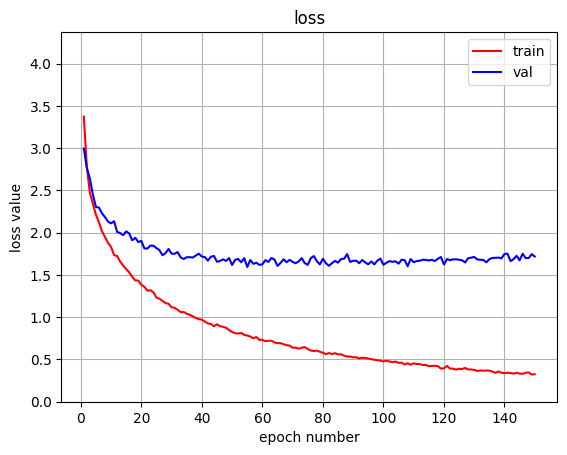

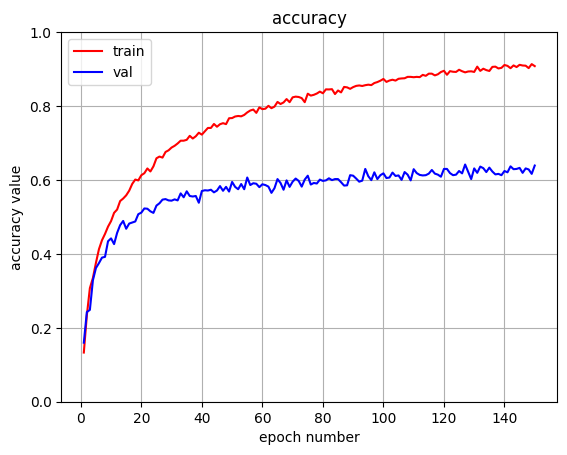

In [23]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()